# Detecting network intrusions & anomalies with higher-order topological kernels via quantum computation 

### 0. CONSTRUCTING NUMPY DATASETS

In [ ]:
import pandas as pd
import numpy as np

# Load the CSV from big dataset
filename = 'BCCC-CIC-CSE-IDS2018/Friday-02-03-2018/friday_02_03_2018_bot/friday_02_03_2018_bot.csv'

# Load the first 50 rows
df = pd.read_csv(filename, nrows=500)

# Select the top 5 anomaly-related features
selected_features = [
    'total_payload_bytes',
    'bytes_rate',
    'packets_rate',
    'avg_segment_size',
    'duration',
    'fwd_bytes_rate',
    'bwd_bytes_rate',
    'syn_flag_counts'

]

# Extract the relevant features
features_df = df[selected_features]

# # Save as CSV
# features_df.to_csv('CSV-500-botnet-benign.csv', index=False)

# Save as a NumPy array
features_array = features_df.to_numpy()
np.save('500-botnet-attack.npy', features_array)


: 

## BEGIN - TRAINING VECTORS & LOAD DATA

In [46]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
from quask.core import Ansatz, Kernel, KernelFactory, KernelType, Operation

from quask.core_implementation import QiskitKernel

In [ ]:
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler

# # Specify the columns you want to load
# # cols = ["duration", "packets_rate", "total_payload_bytes", "syn_flag_counts", "avg_segment_size", "fwd_bytes_rate", "bwd_bytes_rate", "ack_flag_counts", "fwd_avg_segment_size", "packets_count", "bytes_rate", "avg_fwd_bytes_per_bulk", "idle_mean", "fwd_packets_IAT_mean", "payload_bytes_variance"]

# # 8
# cols = ["duration", "packets_rate", "total_payload_bytes", "bytes_rate", "syn_flag_counts", "avg_segment_size", "fwd_bytes_rate", "bwd_bytes_rate"]

# # 11
# # cols = ['src_port', 'duration', 'bytes_rate', 'packets_IAT_cov', 'packets_IAT_variance', 'fwd_packets_IAT_median', 'bwd_packets_IAT_std', 'bwd_packets_IAT_variance', 'min_bwd_packets_delta_time', 'mode_packets_delta_time', 'median_bwd_packets_delta_time']

# # 10
# # cols = ['src_port', 'duration', 'bytes_rate', 'packets_IAT_cov', 'packets_IAT_variance', 'fwd_packets_IAT_median', 'bwd_packets_IAT_std', 'min_bwd_packets_delta_time', 'mode_packets_delta_time', 'median_bwd_packets_delta_time']

# # 18
# # cols = ['src_port', 'duration', 'payload_bytes_max', 'payload_bytes_std',
# #        'fwd_payload_bytes_variance', 'bwd_median_header_bytes', 'down_up_rate',
# #        'avg_bwd_bytes_per_bulk', 'packet_IAT_min', 'fwd_packets_IAT_min',
# #        'fwd_packets_IAT_mode', 'max_bwd_packets_delta_time',
# #        'mean_bwd_packets_delta_time', 'variance_bwd_packets_delta_time',
# #        'cov_bwd_packets_delta_time', 'skewness_fwd_packets_delta_time',
# #        'mode_bwd_packets_delta_len', 'mode_fwd_packets_delta_len']

# # Load only the first 200 rows and selected columns
# qX1 = pd.read_csv(
#     'BCCC-CIC-CSE-IDS2018/Tuesday_20_02_2018/tuesday_20_02_2018_benign/tuesday_20_02_2018_benign.csv',
#     usecols=cols,
#     nrows=50
# ).to_numpy()

# qX2 = pd.read_csv(
#     'BCCC-CIC-CSE-IDS2018/Tuesday_20_02_2018/tuesday_20_02_2018_loic_http/tuesday_20_02_2018_loic_http.csv',
#     usecols=cols,
#     nrows=50
# ).to_numpy()


# # Transform separately
# # scaler = MinMaxScaler(feature_range=(-1, 1))
# # scaler.fit(np.vstack([qX1, qX2]))

# # qX1 = scaler.transform(qX1)
# # qX2 = scaler.transform(qX2)


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

# --- Load ---
df_attack = pd.read_csv(
    'BCCC-CIC-CSE-IDS2018/Tuesday_20_02_2018/tuesday_20_02_2018_loic_http/tuesday_20_02_2018_loic_http.csv',
    nrows=50
)
df_benign = pd.read_csv(
    'BCCC-CIC-CSE-IDS2018/Tuesday_20_02_2018/tuesday_20_02_2018_benign/tuesday_20_02_2018_benign.csv',
    nrows=50
)

# --- Keep numeric columns ---
X_attack = df_attack.select_dtypes(include=[np.number]).copy()
X_benign = df_benign.select_dtypes(include=[np.number]).copy()

# --- Replace inf with NaN ---
X_attack.replace([np.inf, -np.inf], np.nan, inplace=True)
X_benign.replace([np.inf, -np.inf], np.nan, inplace=True)

# --- Drop columns with >20% missing in attack ---
miss_thresh = 0.2
good_cols = X_attack.isnull().mean() < miss_thresh
X_attack = X_attack.loc[:, good_cols]
X_benign = X_benign.loc[:, good_cols]

# --- Drop single-value columns (attack) ---
multi_cols = X_attack.nunique()[X_attack.nunique() > 1].index
shared_cols = [col for col in multi_cols if col in X_benign.columns]
X_attack = X_attack[shared_cols]
X_benign = X_benign[shared_cols]

# --- Drop highly collinear columns (corr > 0.95) ---
corr = X_attack.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
X_attack = X_attack.drop(columns=to_drop)
X_benign = X_benign.drop(columns=to_drop)

# --- Drop any column from benign that still has NaNs ---
no_nan_cols = X_benign.columns[~X_benign.isnull().any()]
X_attack = X_attack[no_nan_cols]
X_benign = X_benign[no_nan_cols]


qX1 = X_benign
qX2 = X_attack

qX1 = qX1.loc[~(qX1 == 0.0).all(axis=1)]
qX2 = qX2.loc[~(qX2 == 0.0).all(axis=1)]
# 1. Combine and label
X = pd.concat([qX1, qX2], axis=0)
y = np.array([0] * len(qX1) + [1] * len(qX2))  # 0 = benign, 1 = attack

# 2. Train an XGBoost classifier
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',  # suppress warning
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)
model.fit(X, y)

# 3. Get feature importances and pick top 10
importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.nlargest(8).index.tolist()
print("Top-10 features by importance:")
for i, feat in enumerate(top_features, 1):
    print(f"{i}. {feat} ({importances[feat]:.4f})")

# 4. Re-slice your datasets to only those top features
qX1 = qX1[top_features].copy()
qX2 = qX2[top_features].copy()

print("\nAfter selecting top features:")
# print("Benign shape:", qX1_top.shape)
# print("Attack shape:", qX2_top.shape)
# --- Normalize to [-1, 1] ---
# scaler = MinMaxScaler(feature_range=(-1, 1))
# combined_scaled = pd.concat([qX1, qX2])
# scaler.fit(combined_scaled)

# qX1 = pd.DataFrame(scaler.transform(qX1), columns=top_features)
# qX2 = pd.DataFrame(scaler.transform(qX2), columns=top_features)

# --- Final Output ---
print("Final selected features:", qX2.columns)
print("Benign shape:", qX1.shape)
print("Attack shape:", qX2.shape)


/mnt/c/users/maryc/onedrive/desktop/Quantum Research 2025/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:10:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top-10 features by importance:
1. src_port (1.0000)
2. duration (0.0000)
3. packet_IAT_min (0.0000)
4. packets_IAT_median (0.0000)
5. packets_IAT_cov (0.0000)
6. fwd_packets_IAT_min (0.0000)
7. fwd_packets_IAT_median (0.0000)
8. bwd_packets_IAT_min (0.0000)

After selecting top features:
Final selected features: Index(['src_port', 'duration', 'packet_IAT_min', 'packets_IAT_median',
       'packets_IAT_cov', 'fwd_packets_IAT_min', 'fwd_packets_IAT_median',
       'bwd_packets_IAT_min'],
      dtype='object')
Benign shape: (50, 8)
Attack shape: (50, 8)


In [150]:
import os
from quask.core_implementation.qiskit_kernel import QiskitKernel
from quask.core import KernelType
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
from quask.core import KernelFactory, Ansatz

data_dir = 'ATTACKDATA/0.02/'

# SIMULATED AER BACKEND
def create_qiskit_noiseless(ansatz, measurement: str, type: KernelType):
    # Here platform="infty_shots" forces Estimator/Aer path inside QiskitKernel
    return QiskitKernel(
        ansatz,
        measurement,
        type,
        platform="infty_shots",
        n_shots=None  # None means no sampling, use statevector/estimator
    )

# REAL QUANTUM BACKEND
_service = QiskitRuntimeService(name="cotrum")
backend = _service.backend("ibm_rensselaer")
options = {
    "dynamical_decoupling": {"sequence_type": "XX", "enable": False},
    "twirling": {"enable_gates": False, "enable_measure": False, "num_randomizations": "auto", "shots_per_randomization": "auto"}
}

# Example factory for a real IBM backend with given options
def create_qiskit_ibm(ansatz, measurement: str, type: KernelType):
    return QiskitKernel(
        ansatz,
        measurement,
        type,
        platform="ibm_quantum",    # or leave default so QiskitKernel picks job mode
        n_shots=2048,
        options=options,
        backend=backend,
    )

# Instantiate a machine learning model
model = SVC(kernel='precomputed')

# Register the noiseless factory
# KernelFactory.add_implementation('qiskit_noiseless', create_qiskit_noiseless)
# Register the IBM backend factory
# KernelFactory.add_implementation('qiskit_ibm', create_qiskit_ibm)

# Choose which one is the default for create_kernel calls:
KernelFactory.set_current_implementation('qiskit_noiseless')
# ...later, if you want to switch:
# KernelFactory.set_current_implementation('qiskit_ibm')

ansatz = Ansatz(n_features=8, n_qubits=4, n_operations=8)
ansatz.initialize_to_identity()
# e.g. set operations...
ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.02)
ansatz.change_operation(1, new_feature=1, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.02)
ansatz.change_operation(2, new_feature=2, new_wires=[2, 3], new_generator="XZ", new_bandwidth=0.02)
ansatz.change_operation(3, new_feature=3, new_wires=[3, 0], new_generator="YX", new_bandwidth=0.02)
ansatz.change_operation(4, new_feature=4, new_wires=[0, 1], new_generator="YY", new_bandwidth=0.02)
ansatz.change_operation(5, new_feature=5, new_wires=[1, 2], new_generator="YZ", new_bandwidth=0.02)
ansatz.change_operation(6, new_feature=6, new_wires=[2, 3], new_generator="ZX", new_bandwidth=0.02)
ansatz.change_operation(7, new_feature=7, new_wires=[3, 0], new_generator="ZY", new_bandwidth=0.02)
# 8
# ansatz.change_operation(8, new_feature=8, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.1)
# ansatz.change_operation(9, new_feature=9, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.1)
# ansatz.change_operation(10, new_feature=10, new_wires=[2, 3], new_generator="XZ", new_bandwidth=0.1)
# ansatz.change_operation(11, new_feature=11, new_wires=[3, 0], new_generator="YX", new_bandwidth=0.1)
# ansatz.change_operation(12, new_feature=12, new_wires=[0, 1], new_generator="YY", new_bandwidth=0.1)
# ansatz.change_operation(13, new_feature=13, new_wires=[1, 2], new_generator="YZ", new_bandwidth=0.1)
# ansatz.change_operation(14, new_feature=14, new_wires=[2, 3], new_generator="ZX", new_bandwidth=0.1)
# # 20
# ansatz.change_operation(15, new_feature=15, new_wires=[3, 0], new_generator="ZY", new_bandwidth=0.1)
# ansatz.change_operation(16, new_feature=16, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.1)
# ansatz.change_operation(17, new_feature=17, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.1)
# ansatz.change_operation(18, new_feature=18, new_wires=[2, 3], new_generator="XZ", new_bandwidth=0.1)
# ansatz.change_operation(19, new_feature=19, new_wires=[3, 0], new_generator="YX", new_bandwidth=0.1)

kernel = KernelFactory.create_kernel(ansatz, "ZZZZ", KernelType.FIDELITY)

for fname in os.listdir(data_dir):
    # only consider benign files
    if fname.endswith('.npy') and 'benign' in fname:
        benign_path = os.path.join(data_dir, fname)
        # construct the matching attack filename
        attack_fname = fname.replace('benign', 'attack')
        attack_path = os.path.join(data_dir, attack_fname)

        if os.path.exists(attack_path):
            # load arrays
            qX1 = np.load(benign_path, allow_pickle=True)
            qX2 = np.load(attack_path, allow_pickle=True)

            columns = [3, 4, 5, 6, 7, 8, 9, 10]
            qX1 = qX1[:20,columns]
            qX2 = qX2[:20,columns]

            qX = np.row_stack([qX1, qX2])
            qy = np.array([-1] * len(qX1) + [1] * len(qX2))


            qX_train, qX_test, qy_train, qy_test = train_test_split(qX, qy, test_size=0.2, random_state=42)

            print("Shape training set:", qX_train.shape, qy_train.shape)
            print("Shape testing set:", qX_test.shape, qy_test.shape)
            print("Example of feature:", qX_train[0])
            print("Example of label:", qy_train[0])

            # kernel.service = _service # This will invoke whichever implementation is current (e.g., create_qiskit_noiseless).

            K_train = kernel.build_kernel(qX_train, qX_train, matrix="train") # train data

            model.fit(K_train, qy_train)
        
            # Predict the labels for the test data
            K_test = kernel.build_kernel(qX_test, qX_train, matrix="test")
            y_pred = model.predict(K_test)

            # Calculate the accuracy
            accuracy = np.sum(qy_test == y_pred) / len(qy_test)
            print(f"Accuracy for {fname} is {accuracy}")

            
            



Shape training set: (32, 8) (32,)
Shape testing set: (8, 8) (8,)
Example of feature: [1.9073486328125e-06 1048576.0 0 0.0 1 0.0 0.0 0.0]
Example of label: 1
Accuracy for bfftpbenign_200.npy is 1.0
Shape training set: (32, 8) (32,)
Shape testing set: (8, 8) (8,)
Example of feature: [5.005551099777222 1.7980038202787614 1010 201.77598427572767 2.0
 112.22222222222224 129.05671865556442 72.71926562016324]
Example of label: 1
Accuracy for bfwebbenign_200.npy is 1.0
Shape training set: (32, 8) (32,)
Shape testing set: (8, 8) (8,)
Example of feature: [0.0129351615905761 695.7779334242637 455 35175.43996755999 2.0
 50.55555555555556 25202.622921812217 9972.81704574778]
Example of label: 1
Accuracy for botnetbenign_200.npy is 1.0
Shape training set: (32, 8) (32,)
Shape testing set: (8, 8) (8,)
Example of feature: [2481.928843975067 0.0233689213696823 946 0.3811551657882676 2
 16.310344827586206 0.1732523480855761 0.2079028177026914]
Example of label: 1
Accuracy for dosslowlorisbenign_200.npy i

In [141]:
print(qX_train)
print(qy_train)


[[5.011981010437012 1.9952190519429087 2476 494.0162372610644 2 247.6
  116.91983644385448 377.0964008172099]
 [2.2966010570526123 6.531391228762448 2729 1188.2777775528482 2
  181.9333333333333 499.86914204128607 688.4086355115621]
 [5.0062408447265625 1.7977560966688917 946 188.96414082764127 2
  105.11111111111111 111.46087799347129 77.50326283417]
 [170.8541030883789 0.1755884082250087 4619 27.034761919710512 2
  153.96666666666667 4.190710009636875 22.844051910073635]
 [5.011401891708374 1.9954496199048657 2364 471.7242901455103 2 236.4
  111.34608879069152 360.3782013548188]
 [90.11291003227234 0.3107212938742328 3750 41.61445900101333 2
  133.92857142857142 15.447287181176147 26.167171819837183]
 [72.61678791046143 0.3993566891964132 6708 92.37533348722552 2
  231.31034482758625 3.855857688792955 88.51947579843255]
 [0.1282589435577392 148.13781770661967 4368 34056.10461802709 2
  229.8947368421053 4342.777076978272 29713.32754104882]
 [0.940201997756958 10.636012286569292 584 6

In [116]:
qX1 = np.load('ATTACKDATA/loicbenign_200.npy', allow_pickle=True)
qX2 = np.load('ATTACKDATA/loicattack_200.npy', allow_pickle=True)

In [117]:
columns = [3, 4, 5, 6, 7, 8, 9, 10]
qX1 = qX1[:50,columns]
qX2 = qX2[:50,columns]

In [118]:
qX = np.row_stack([qX1, qX2])
qy = np.array([-1] * len(qX1) + [1] * len(qX2))

print(f"{qX.shape=}")
print(f"{qy.shape=}")

qX.shape=(100, 8)
qy.shape=(100,)


In [119]:
qX_train, qX_test, qy_train, qy_test = train_test_split(qX, qy, test_size=0.2, random_state=42)

print("Shape training set:", qX_train.shape, qy_train.shape)
print("Shape testing set:", qX_test.shape, qy_test.shape)
print("Example of feature:", qX_train[0])
print("Example of label:", qy_train[0])

Shape training set: (80, 8) (80,)
Shape testing set: (20, 8) (20,)
Example of feature: [101.0412459373474 0.0890725358392811 984 9.738597251761409 2
 109.33333333333331 0.1979389685317359 9.540658283229671]
Example of label: 1


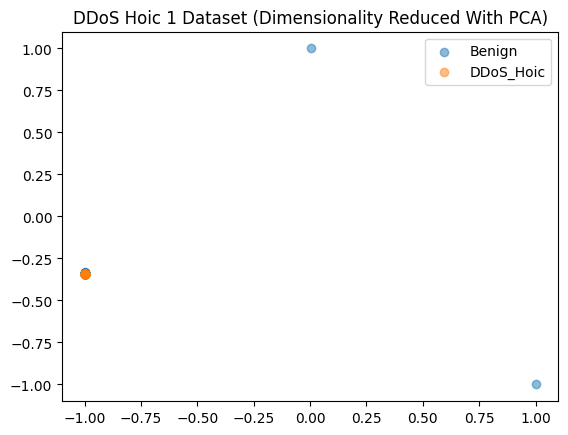

In [120]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


class_labels = [r'Benign', r'DDoS_Hoic']
pca = PCA(n_components=2).fit(qX_train)
X_train = pca.transform(qX_train)
X_test = pca.transform(qX_test)

samples = np.append(X_train, X_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
X_train = minmax_scale.transform(X_train)
X_test = minmax_scale.transform(X_test)

training_input = {key: (X_train[qy_train == k, :])[:320] for k, key in enumerate(class_labels)}
test_input = {key: (X_test[qy_test == k, :])[:80] for k, key in enumerate(class_labels)}


label_mapping = { -1: 'Benign', 1: 'DDoS_Hoic' }


for k in [-1, 1]:
    x_axis_data = X_train[qy_train == k, 0][:320]
    y_axis_data = X_train[qy_train == k, 1][:320]
    plt.scatter(x_axis_data, y_axis_data, label=label_mapping[k], alpha=0.5)

plt.title("DDoS Hoic 1 Dataset (Dimensionality Reduced With PCA)")
plt.legend()
plt.show()

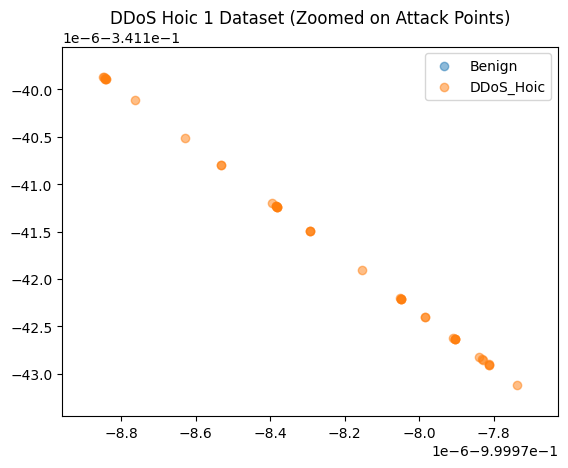

In [121]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

class_labels = [r'Benign', r'DDoS_Hoic']
pca = PCA(n_components=2).fit(qX_train)
X_train = pca.transform(qX_train)
X_test  = pca.transform(qX_test)

# scale everything to [-1,1]
samples = np.vstack((X_train, X_test))
scaler  = MinMaxScaler((-1, 1)).fit(samples)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

# plot both classes
for k, label in zip([-1, 1], class_labels):
    pts = X_train[qy_train == k, :320]
    plt.scatter(pts[:,0], pts[:,1], label=label, alpha=0.5)

# now zoom in on the attack (DDoS_Hoic, which is k==1)
attack_pts = X_train[qy_train == 1, :320]
x_min, x_max = attack_pts[:,0].min(), attack_pts[:,0].max()
y_min, y_max = attack_pts[:,1].min(), attack_pts[:,1].max()

# add a little padding
pad_x = (x_max - x_min) * 0.1
pad_y = (y_max - y_min) * 0.1

plt.xlim(x_min - pad_x, x_max + pad_x)
plt.ylim(y_min - pad_y, y_max + pad_y)

plt.title("DDoS Hoic 1 Dataset (Zoomed on Attack Points)")
plt.legend()
plt.show()


/tmp/ipykernel_16304/2285627515.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


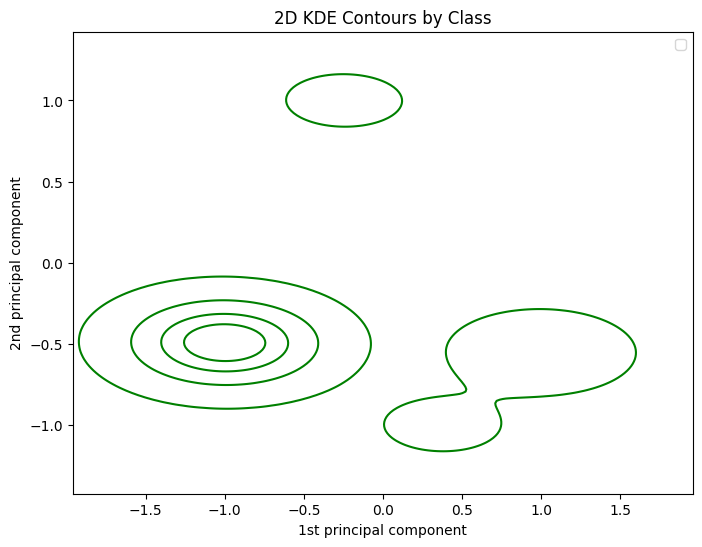

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for k, color in zip([-1, 1], ['green','red']):
    mask = (qy_train == k)
    sns.kdeplot(
        x=X_train[mask,0],
        y=X_train[mask,1],
        levels=5,
        thresh=0.05,
        fill=False,
        color=color,
        label=label_mapping[k]
    )

plt.title("2D KDE Contours by Class")
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.legend()
plt.show()


In [103]:
import numpy as np

# how many total points?
print("Total train points:", X_train.shape[0])

# how many unique 2-D points?
uniq = np.unique(np.round(X_train, 6), axis=0)
print("Unique (x,y) coords after PCA+scaling:", uniq.shape[0])


Total train points: 80
Unique (x,y) coords after PCA+scaling: 4


In [104]:
print("Benign samples in training:", np.sum(qy_train == -1))
print("Bot samples in training:", np.sum(qy_train == 1))


Benign samples in training: 38
Bot samples in training: 42


In [105]:
# Instantiate a machine learning model
model = SVC(kernel='precomputed')

## BUILD QUANTUM KERNEL

In [106]:
from quask.core_implementation.qiskit_kernel import QiskitKernel
from quask.core import KernelType
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler

# SIMULATED AER BACKEND
def create_qiskit_noiseless(ansatz, measurement: str, type: KernelType):
    # Here platform="infty_shots" forces Estimator/Aer path inside QiskitKernel
    return QiskitKernel(
        ansatz,
        measurement,
        type,
        platform="infty_shots",
        n_shots=None  # None means no sampling, use statevector/estimator
    )

# REAL QUANTUM BACKEND
# _service = QiskitRuntimeService()  # ensure credentials/configured
# backend = _service.backend("ibm_rensselaer", instance="rpi-rensselaer/classes/itws-4940-callab")
# options = {
#     "dynamical_decoupling": {"sequence_type": "XX", "enable": False},
#     "twirling": {"enable_gates": False, "enable_measure": False, "num_randomizations": "auto", "shots_per_randomization": "auto"}
# }

# # Example factory for a real IBM backend with given options
# def create_qiskit_ibm(ansatz, measurement: str, type: KernelType):
#     return QiskitKernel(
#         ansatz,
#         measurement,
#         type,
#         platform="ibm_quantum",    # or leave default so QiskitKernel picks job mode
#         n_shots=2048,
#         options=options,
#         backend=backend,
#     )

Add to Factory

In [107]:
from quask.core import KernelFactory, Ansatz

# Register the noiseless factory
# KernelFactory.add_implementation('qiskit_noiseless', create_qiskit_noiseless)
# Register the IBM backend factory
# KernelFactory.add_implementation('qiskit_ibm', create_qiskit_ibm)

# Choose which one is the default for create_kernel calls:
KernelFactory.set_current_implementation('qiskit_noiseless')
# ...later, if you want to switch:
# KernelFactory.set_current_implementation('qiskit_ibm')

In [108]:
# print(qX_train)
# print(qy_train)

Define ansatz ops

In [109]:
# # Define some information about the parameterized quantum circuit
# N_FEATURES = 3
# N_QUBITS = 3

# # Create a random operation
# allowed_generators = Operation.PAULI_GENERATORS
# generators = np.random.choice(allowed_generators)

# allowed_qubits = list(range(N_QUBITS))
# wires = np.random.choice(allowed_qubits, 2, replace=False)

# allowed_features_plus_constant_element = list(range(N_FEATURES + 1))
# feature = np.random.choice(allowed_features_plus_constant_element)

# bandwidth = np.random.uniform(0.0, 1.0)

# operation = Operation(generators, wires, feature, bandwidth)
# print(operation)

In [110]:
# N_FEATURES = 3
# N_OPERATIONS = 3
# N_QUBITS = 3
# ansatz = Ansatz(n_features=N_FEATURES, n_qubits=N_QUBITS, n_operations=N_OPERATIONS)
# ansatz.initialize_to_identity()

# # parameterized rotation R_{ZZ}(x_0) on the qubits 0, 1
# ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="ZZ", new_bandwidth=1.0)

# # parameterized rotation R_{XX}(x_1) on the qubits 0, 1
# ansatz.change_operation(1, new_feature=1, new_wires=[0, 1], new_generator="XX", new_bandwidth=1.0)

# # constant R_x(0.123) of the qubit 1 (the second)
# ansatz.change_operation(2, new_feature=2, new_wires=[0, 1], new_generator="IX", new_bandwidth=0.123)

In [111]:
# ansatz = Ansatz(n_features=1, n_qubits=1, n_operations=1)
# ansatz.initialize_to_identity()
# # e.g. set operations...
# ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.1)
# ansatz.change_operation(1, new_feature=1, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.1)
# ansatz.change_operation(2, new_feature=2, new_wires=[2, 1], new_generator="XZ", new_bandwidth=0.1)

In [112]:
ansatz = Ansatz(n_features=8, n_qubits=4, n_operations=8)
ansatz.initialize_to_identity()
# e.g. set operations...
ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.1)
ansatz.change_operation(1, new_feature=1, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.1)
ansatz.change_operation(2, new_feature=2, new_wires=[2, 3], new_generator="XZ", new_bandwidth=0.1)
ansatz.change_operation(3, new_feature=3, new_wires=[3, 0], new_generator="YX", new_bandwidth=0.1)
ansatz.change_operation(4, new_feature=4, new_wires=[0, 1], new_generator="YY", new_bandwidth=0.1)
ansatz.change_operation(5, new_feature=5, new_wires=[1, 2], new_generator="YZ", new_bandwidth=0.1)
ansatz.change_operation(6, new_feature=6, new_wires=[2, 3], new_generator="ZX", new_bandwidth=0.1)
ansatz.change_operation(7, new_feature=7, new_wires=[3, 0], new_generator="ZY", new_bandwidth=0.1)
# 8
# ansatz.change_operation(8, new_feature=8, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.1)
# ansatz.change_operation(9, new_feature=9, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.1)
# ansatz.change_operation(10, new_feature=10, new_wires=[2, 3], new_generator="XZ", new_bandwidth=0.1)
# ansatz.change_operation(11, new_feature=11, new_wires=[3, 0], new_generator="YX", new_bandwidth=0.1)
# ansatz.change_operation(12, new_feature=12, new_wires=[0, 1], new_generator="YY", new_bandwidth=0.1)
# ansatz.change_operation(13, new_feature=13, new_wires=[1, 2], new_generator="YZ", new_bandwidth=0.1)
# ansatz.change_operation(14, new_feature=14, new_wires=[2, 3], new_generator="ZX", new_bandwidth=0.1)
# # 20
# ansatz.change_operation(15, new_feature=15, new_wires=[3, 0], new_generator="ZY", new_bandwidth=0.1)
# ansatz.change_operation(16, new_feature=16, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.1)
# ansatz.change_operation(17, new_feature=17, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.1)
# ansatz.change_operation(18, new_feature=18, new_wires=[2, 3], new_generator="XZ", new_bandwidth=0.1)
# ansatz.change_operation(19, new_feature=19, new_wires=[3, 0], new_generator="YX", new_bandwidth=0.1)


Create KernelFactory

In [113]:
# kernel = KernelFactory.create_kernel(ansatz, "ZZZ", KernelType.FIDELITY)

In [114]:
kernel = KernelFactory.create_kernel(ansatz, "ZZZZ", KernelType.FIDELITY)

# kernel.service = _service # This will invoke whichever implementation is current (e.g., create_qiskit_noiseless).

Set up a Session

In [115]:
# batch all jobs in a session
# with Session(backend=backend) as session:
#     kernel._session = session
#     kernel._sampler = Sampler(session=session)

#     K_train = kernel.build_kernel(X_train, X_train, matrix="train")


K_train = kernel.build_kernel(qX_train, qX_train, matrix="train") # train data
print(K_train)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x79431b995d80>>
Traceback (most recent call last):
  File "/mnt/c/users/maryc/onedrive/desktop/Quantum Research 2025/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


[[ 1.00000000e+00  6.84899463e-01 -2.71200074e-01  6.00828281e-01
   9.80063039e-01 -4.20245591e-01  6.16914493e-01 -7.14006038e-01
  -9.58916677e-01 -3.54357918e-01 -6.58151178e-01  6.26801206e-01
  -6.14758480e-01 -7.42537626e-01  1.53164225e-01 -9.51038146e-01
  -6.27376532e-01 -6.65189613e-01  1.06880541e-01 -3.21351554e-02
   5.37561527e-03 -6.11510557e-01 -8.72526274e-01  1.03624977e-01
  -7.47482682e-01  1.06732225e-01 -6.53180831e-01 -2.04023898e-02
  -4.60613337e-01 -3.70792775e-01  2.80548949e-01 -5.54170200e-01
  -1.63170546e-01  5.08270883e-01 -9.05064974e-01  7.20459112e-01
  -9.98032773e-01  9.21013776e-01 -9.33496327e-02 -9.58510128e-02
   9.88769770e-01 -6.78254368e-01 -2.75180712e-01  6.06705281e-01
  -3.70146837e-01 -5.88106203e-01  3.77341550e-01  9.55271491e-01
   9.39375394e-01 -7.79949744e-01 -4.45718647e-01  4.92908517e-01
  -5.04371005e-01  6.13881830e-01 -1.45501763e-01 -5.46887828e-01
  -2.59426820e-01 -1.52727121e-01 -5.19304914e-01  8.99980528e-01
   9.95002

Fit trained data to model

In [ ]:
model.fit(K_train, qy_train)

SVC(kernel='precomputed')

In [ ]:
# Predict the labels for the test data
K_test = kernel.build_kernel(qX_test, qX_train, matrix="test")
y_pred = model.predict(K_test)

In [ ]:
# Calculate the accuracy
accuracy = np.sum(qy_test == y_pred) / len(qy_test)
print("Accuracy:", accuracy)

Accuracy: 1.0


## Visualizations

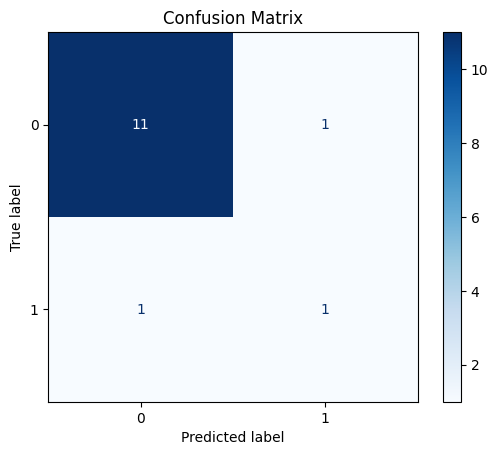

In [140]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

cm = confusion_matrix(qy_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()